<a href="https://colab.research.google.com/github/AjeetSingh02/Notebooks/blob/master/VaexReport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is Vaex?

Vaex is a **memory-efficient** and **incredibly fast** Python library that makes working with huge datasets a breeze. It does **memory-mapping** and never touches or copies the data unless explicitly requested.

This makes it possible to **work with datasets that are the size of your hard drive**. Furthermore, it does **lazy computations**, works with **virtual columns**, does efficient **data cleansing**, computes fast **N-dimensional statistics**, creates **interactive visualization** and more.

It can calculate statistics such as mean, sum, count, standard deviation etc, on an N-dimensional grid up to a billion (10^9) objects/rows per second

**What is Memory Mapping?**



A technique where you tell the operating system that you want a piece of memory to be in sync with the content on disk. It is technically quite similar to a swap disk. If a piece of memory isn’t modified, or not used for a while, the kernel will discard it so that RAM can be reused. Also, all processes that have the same file open share the same physical memory.

Memory mapping is excellent, you can memory-map a 1 TB file instantly, and the kernel smartly decides what to read or discard. Now imagine you want to filter out some rows which contain irrelevant data. In pandas, with our 1 TB DataFrame we could do **df_filtered = df[df.x > 0]**, which makes a copy of all the data, taking up another 0.8 TB… well, actually you will see a MemoryError.

#Installation and Import

In [0]:
%%capture
! pip install --upgrade vaex

In [0]:
import vaex
import pandas as pd

import numpy as np

In [0]:
path = "/content/sample_data/california_housing_train.csv"
pandas_df = pd.read_csv(path) 
vaex_df = vaex.from_csv(path, copy_index=True)

# Vaex Features

#1. Vaex has same API as Pandas for column access

In [0]:
vaex_df.head(1)

#,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,index
0,-114.31,34.19,15,5612,1283,1015,472,1.4936,66900,0


In [0]:
vaex_df.longitude[3:7]

Expression = longitude
Length: 4 dtype: float64 (column)
---------------------------------
0  -114.57
1  -114.57
2  -114.58
3  -114.58

In [0]:
vaex_df[vaex_df.housing_median_age > 30]["housing_median_age", "total_rooms"][:5]

#,housing_median_age,total_rooms
0,41,812
1,34,4789
2,46,1497
3,48,1291
4,31,2478


#2. Vaex is lazy


When executing an expression such as **np.sqrt(ds.x^2 + ds.y^2)**, **no computations happen**. A vaex expression object is created instead, and when printed out it shows some preview values.

With the expression system, **vaex performs calculations only when needed**.

In [0]:
np.sqrt(vaex_df.housing_median_age ** 2+ vaex_df.total_rooms ** 2)

Expression = sqrt(((housing_median_age ** 2) + (total_rooms ** 2)))
Length: 17,000 dtype: float64 (expression)
------------------------------------------
    0  5612.02
    1  7650.02
    2  720.201
    3  1501.07
    4  1454.14
     ...      
16995  2217.61
16996  2349.28
16997  2677.05
16998  2672.07
16999  1820.74

**NOTE**: Only the values you see are evaluated.

#3. Virtual columns


We can also add expressions to a DataFrame, which result in virtual columns. A virtual column behaves like a regular column but occupies no memory. Vaex makes no distinction between real and virtual columns, they are treated on equal footing.

In [0]:
vaex_df['r'] = np.sqrt(vaex_df.housing_median_age ** 2+ vaex_df.total_rooms ** 2)  # add a (virtual) column that will be computed on the fly

In [0]:
vaex_df.r

Expression = r
Length: 17,000 dtype: float64 (column)
--------------------------------------
    0  5612.02
    1  7650.02
    2  720.201
    3  1501.07
    4  1454.14
     ...      
16995  2217.61
16996  2349.28
16997  2677.05
16998  2672.07
16999  1820.74

In [0]:
vaex_df.mean(vaex_df.housing_median_age), vaex_df.mean(vaex_df.r)  # calculate statistics on normal and virtual columns

(array(28.58935294), array(2644.06865098))

**What if an expression is really expensive to compute on the fly?** 

By using Pythran or Numba, we can optimize the computation using manual Just-In-Time (JIT) compilation.

**If we have plenty of RAM?** 

We can materialize the column. You can choose to squeeze out extra performance at the cost of RAM.

In [0]:
df_m = vaex_df.materialize('r') # A new dataframe will be returned

#4. Data cleansing

Filtering of a DataFrame, such as **ds_filtered = ds[ds.x >0]** merely results in a reference to the existing data plus a boolean mask keeping track which rows are selected and which are not. Almost no memory usage, and no memory copying going on.

In [0]:
temp1 = vaex_df[vaex_df.housing_median_age < 30]  # easily filter your DataFrame, without making a copy
temp1[:5][['housing_median_age', 'total_rooms']]  # take the first five rows, and only the 'housing_median_age' and 'total_rooms' column (no memory copy!)

#,housing_median_age,total_rooms
0,15,5612
1,19,7650
2,17,720
3,14,1501
4,20,1454


When dealing with huge datasets, say a billion rows (10^9), computations with the data can waste memory, up to 8 GB for a new column. Instead, vaex uses lazy computation, storing only a representation of the computation, and computations are done on the fly when needed.

This is **similar to how TensorFlow works**. Like TensorFlow which creates DAG (Directed Ascyclic Graph), Vaex creates representation of the computation. The benifit of this method is that only when there is requirement of the output, the calulations will be done. Till then there will be no calculation and thus the RAM which is utilized in storing data will be free.

When you apply your operations, you can print out the dataframe, and directly see a preview (head and tail), without any delay. **Only the values you see are evaluated.**

In [0]:
# creates an expression (nothing is computed)
some_expression = vaex_df.housing_median_age + vaex_df.total_rooms
some_expression  # for convenience, we print out some values

Expression = (housing_median_age + total_rooms)
Length: 17,000 dtype: float64 (expression)
------------------------------------------
    0  5627
    1  7669
    2   737
    3  1515
    4  1474
    ...    
16995  2269
16996  2385
16997  2694
16998  2691
16999  1872

#5. Statistics on N-d grids

A core feature of Vaex is the extremely efficient calculation of statistics on N-dimensional grids. This is rather useful for making visualisations of large datasets.

In [0]:
vaex_df.count()

array(17000)

In [0]:
vaex_df.mean(vaex_df.total_bedrooms)

array(539.41082353)

In [0]:
vaex_df.head(1)

#,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,index,r
0,-114.31,34.19,15,5612,1283,1015,472,1.4936,66900,0,5612.02


Similar to SQL’s groupby, Vaex uses the **binby** concept, which tells Vaex that a statistic should be calculated on a regular grid (for performance reasons)

In [0]:
xcounts = vaex_df.count(binby=vaex_df.housing_median_age, limits=[-10, 10], shape=64)
xcounts

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   0,   0,  49,
         0,   0,  46,   0,   0, 161,   0,   0,   0, 199,   0,   0, 129,
         0,   0, 151,   0,   0, 178,   0,   0, 172,   0,   0,   0])

This results in a Numpy array with the number counts in 64 bins distributed between x = -10, and x = 10. We can quickly visualize this using Matplotlib.

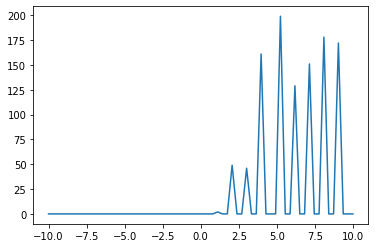

In [0]:
import matplotlib.pylab as plt
plt.plot(np.linspace(-10, 10, 64), xcounts)
plt.show()

We can do the same in 2D as well (this can be generalized to N-D actually!), and display it with Matplotlib.

# Vaex Performance

Compared to Pandas, string operations in Vaex are up to ~30–100x faster on quadcore laptop, and up to a 1000 times faster on a 32 core machine.

**How: The GIL, C++, and ApacheArrow**

Three ingredients are involved: C++, Apache Arrow and the Global Interpreter Lock (GIL). 

In Python multithreading is hampered by the GIL, making all pure Python instructions effectively single threaded. When moving to C++, the GIL can be released and all cores of your machine will be used. To exploit this advantage, **Vaex does all string operations in C++**.

The next ingredient is to define an in-memory and on-disk data structure that is efficient in memory usage, and this is where Apache Arrow comes into play. Apache Arrow defines a well thought out StringArray that can be stored on disk, is friendly to the CPU, and even supports masked/null values. On top of that, it means that all projects supporting the Apache Arrow format will be able to use the same data structure without any memory copying.

**Pandas VS Spark VS Vaex**

Spark performs better than Pandas, which is expected due to multithreading. 
Also, in the experiments Vaex did much better than Spark. 

Overall we can say that if you want to do interactive work on your laptop:

1. Pandas will do in the order of millions of strings per seconds (and does not scale)
2. Spark will do in the order of 10 millions of strings per second (and will scale up with the number of cores and number of machines).
3. Vaex can do in the order of 100 millions of strings per second, and will scale up with the number of cores. On a 32 core machine, we get in the order of a billion of strings per second.

# Conclusion

1. Vaex is very similar to pandas in terms of API. Vaex team has claimed it to be faster than both pandas and Spark.
You can check those results [here](https://towardsdatascience.com/vaex-a-dataframe-with-super-strings-789b92e8d861)


2. Below we can see one functioning which is present in pandas and not in Vaex

In [0]:
# This will give 1st to 4th row of 3rd column (indexing starts from 0)
pandas_df.iloc[1:4, 3]

1    7650.0
2     720.0
3    1501.0
Name: total_rooms, dtype: float64

In [0]:
# This iloc functioning is not supported in Vaex and thus there will be error
vaex_df.iloc[1:4, 3]

AttributeError: ignored

3. Pandas will be around forever, its flexibility is unparalleled, and for a big part responsible for the Python’s popularity in data science [Source: [Article](https://towardsdatascience.com/vaex-a-dataframe-with-super-strings-789b92e8d861) by founder of Vaex]. 

4. There are many functioning of pandas which makes it so much important. Vaex can be a good alternative of Pandas for those functionings which Vaex also supports.

5. But for the functionings which are not supported by Vaex we will have to use pandas only. On top of that Pandas team is working on version 2 which will be targetting the drawbacks of current pandas version. Though there are still no dates for its arrival.